In [1]:
%pip install numpy tensorflow matplotlib

You should consider upgrading via the '/Users/hareramachakraborthy/Desktop/Sentiment Analysis/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install scikit-learn

In [ ]:
%pip install nltk

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.metrics import classification_report, roc_auc_score
import nltk

In [10]:
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet
import random

def synonym_replacement(text, n=1):
    tokens = nltk.word_tokenize(text)
    augmented_texts = []
    for _ in range(n):
        augmented_tokens = []
        for token in tokens:
            synsets = wordnet.synsets(token)
            if synsets:
                synonyms = [lemma.name() for synset in synsets for lemma in synset.lemmas() if lemma.name() != token]
                if synonyms:
                    synonym = random.choice(synonyms)
                    augmented_tokens.append(synonym)
                else:
                    augmented_tokens.append(token)
            else:
                augmented_tokens.append(token)
        augmented_texts.append(' '.join(augmented_tokens))
    return augmented_texts

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hareramachakraborthy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hareramachakraborthy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Set the vocabulary size and maximum sequence length
vocab_size = 20000
max_length = 250

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)

# Perform text augmentation with NLTK
augmented_x_train = []
for review in x_train:
    review_text = ' '.join([str(token) for token in review])
    augmented_reviews = synonym_replacement(review_text)
    for aug_review in augmented_reviews:
        tokens = [int(word) if word.isdigit() else 0 for word in aug_review.split()]
        padded_review = pad_sequences([tokens], maxlen=max_length)[0]
        augmented_x_train.append(padded_review)

augmented_x_train = np.array(augmented_x_train)

# Combine original and augmented data
x_train_combined = np.concatenate((x_train, augmented_x_train), axis=0)
y_train_combined = np.concatenate((y_train, y_train[:len(augmented_x_train)]), axis=0)

In [12]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.0005)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

In [13]:
def predict_sentiment(text, threshold=0.5):
    # Tokenize and pad the input text
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts([text])
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence, maxlen=max_length)
    
    # Make predictions
    prediction = model.predict(text_sequence)
    
    if prediction >= threshold:
        return ["Positive", prediction[0][0]]
    else:
        return ["Negative", 1 - prediction[0][0]]

In [14]:
# Train the model
batch_size = 64
epochs = 3

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

# Plot training and validation loss over epochs
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 170s 430ms/step - Precision: 0.6756 - Recall: 0.6844 - accuracy: 0.6768 - loss: 0.5943 - val_Precision: 0.8741 - val_Recall: 0.8351 - val_accuracy: 0.8574 - val_loss: 0.3621
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 172s 440ms/step - Precision: 0.9068 - Recall: 0.8984 - accuracy: 0.9024 - loss: 0.2693 - val_Precision: 0.9015 - val_Recall: 0.8107 - val_accuracy: 0.8611 - val_loss: 0.3439
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 163s 417ms/step - Precision: 0.9404 - Recall: 0.9370 - accuracy: 0.9388 - loss: 0.1824 - val_Precision: 0.8662 - val_Recall: 0.8747 - val_accuracy: 0.8698 - val_loss: 0.3324


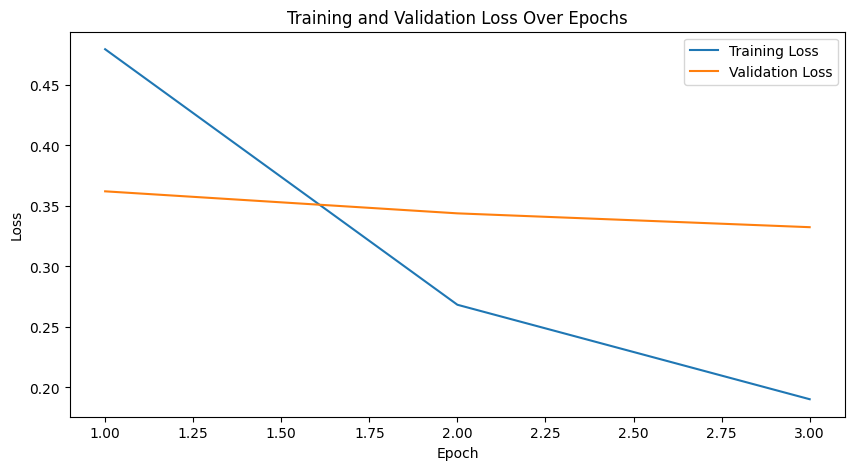

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

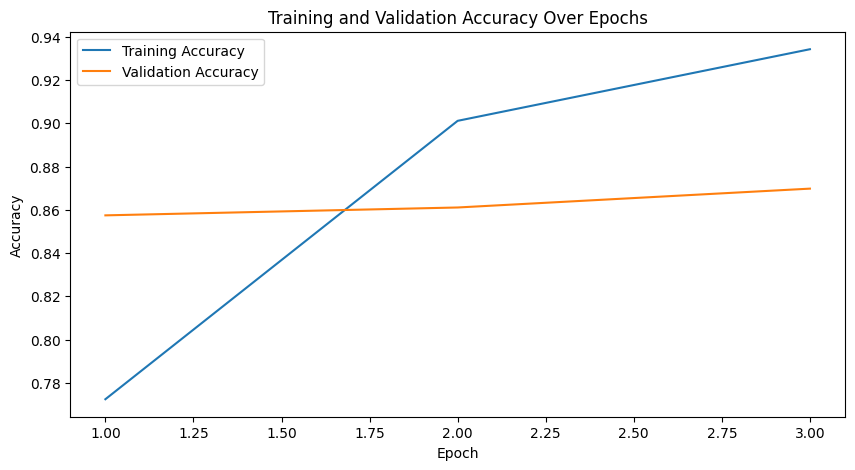

In [16]:
# Plot training and validation accuracy over epochs
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Evaluate the model with additional metrics
y_pred = model.predict(x_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step
ROC-AUC Score: 0.9392725376000002


In [18]:
# Classification report
threshold = 0.5  # Initial threshold
y_pred_binary = (y_pred > threshold).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     12500
           1       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [25]:
# Review Input
sample_review = input("Enter a sample review: ")
sentiment = predict_sentiment(sample_review, threshold=threshold)
print(f"Sentiment: {sentiment[0]}, Confidence: {sentiment[1]}")
sample_review

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sentiment: Negative, Confidence: 0.7174911797046661


'trash movie'

In [26]:
# Evaluate the model with additional metrics
loss, accuracy, precision, recall = model.evaluate(x_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - Precision: 0.8613 - Recall: 0.8770 - accuracy: 0.8698 - loss: 0.3337
Accuracy: 0.8697999715805054
Precision: 0.8661966323852539
Recall: 0.8747199773788452
F1 Score: 0.8704374401808134
